In [ ]:
!gdown --id 1SXRluq9iwhAai0VGdpOfxO5YuRfD0Feo

Downloading...
From: https://drive.google.com/uc?id=1SXRluq9iwhAai0VGdpOfxO5YuRfD0Feo
To: /content/task1_dataset.zip
100% 3.54M/3.54M [00:00<00:00, 219MB/s]


In [ ]:
!unzip -q -o task1_dataset.zip

In [ ]:
import os
import glob
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torchvision import transforms, models

torch.cuda.is_available()

True

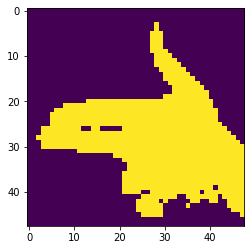

In [ ]:
def processSkinImage(filePath, resize_HW=48):
    # step 1
    # read the image
    original = cv2.imread(filename=filePath)

    # step 2
    # resize the image to
    image_resized = cv2.resize(original, (resize_HW, resize_HW))

    # step 3
    # convert the image from rgb to YCbCr (color space)
    image_ycbcr = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCR_CB)

    # step 4
    # get the central color of the image
    # expected the hand to be in the central of the image
    Cb_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 1]
    Cr_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 2]
    # set the range
    Cb_Difference = 15
    Cr_Difference = 10

    # step 5
    # detect skin pixels
    Cb = image_ycbcr[:, :, 1]
    Cr = image_ycbcr[:, :, 2]
    index = np.where((Cb >= Cb_center_color-Cb_Difference) & (Cb <= Cb_center_color+Cb_Difference)
                     & (Cr >= Cr_center_color-Cr_Difference) & (Cr <= Cr_center_color+Cr_Difference))

    # Mark detected pixels and output
    image_output = np.zeros((resize_HW, resize_HW))
    image_output[index] = 255

    # show image
    return image_output

filePath = "dataset/images/left/left (1).jpg"
plt.imshow(processSkinImage(filePath, resize_HW=48))
plt.show()

In [ ]:
path = './dataset/images'
path_processed = './dataset_processed/images'

# -------------------images processing--------------
for mainDir, subDir, fileList in os.walk(path):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        processedImage = processSkinImage(currentPath)

        new_mainDir = path_processed + mainDir.split(path)[-1]
        if not os.path.exists(new_mainDir):
            os.makedirs(new_mainDir)
        cv2.imwrite(os.path.join(new_mainDir, file), processedImage)

# -----------------label generation----------------
label_path = './dataset_processed/labels'
if not os.path.exists(label_path):
    os.makedirs(label_path)

files = os.listdir(path)
for i, file in enumerate(files):
    subclass_label_path = os.path.join(label_path, file+'.txt')
    with open(subclass_label_path, 'w') as f:
        f.write('#label\n')
    for _ in range(len(os.listdir(os.path.join(path_processed, file)))):
        with open(subclass_label_path, 'a') as f:
            f.write('{:d}\n'.format(i))
    f.close()

In [ ]:
images = []
path_images = './dataset_processed/images'
for mainDir, subDir, fileList in os.walk(path_images):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        images.append(cv2.imread(currentPath)[:, :, 0])
images = np.array(images) / 255
dataset_size, H, W = images.shape
images = images.reshape(dataset_size, -1)


labels = []
path_labels = './dataset_processed/labels'
for file in os.listdir(path_labels):
    labels.append(np.loadtxt(os.path.join(path_labels, file)))
labels = np.array(list(itertools.chain.from_iterable(labels)))
num_classes = int(np.max(labels))+1

images.shape, labels.shape

((78, 2304), (78,))

In [ ]:
dataset = TensorDataset(torch.Tensor(images), torch.LongTensor(labels))
split_ratio = 0.7
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
trainloader = DataLoader(dataset=train_set, batch_size=8, shuffle=True)
testloader = DataLoader(dataset=test_set, batch_size=8, shuffle=True)
print('Data is ready!')

batch_image, batch_label = next(iter(trainloader))
batch_image.shape, batch_label.shape

Data is ready!


(torch.Size([8, 2304]), torch.Size([8]))

In [ ]:
def trainer(model, optimizer, criterion, train_loader, test_loader, model_name="cnn_model.pth", epochs=150):
    if torch.cuda.is_available():
      model.to("cuda")

    train_accs = []
    test_accs = []
    train_losses = []
    test_losses = []
    best_accuracy = 0
    for epoch in range(epochs):
        train_loss = 0.0
        test_loss = 0.0
        total = 0
        correct = 0
        model.train()
        for step, (batch_image, batch_label) in enumerate(tqdm(train_loader)):
            if torch.cuda.is_available():
                batch_image, batch_label = batch_image.to("cuda"), batch_label.to("cuda")
            batch_output = mode(batch_image)
            batch_loss = criterion(batch_output, batch_label)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item()

            # train accuracy
            _, train_predicted = torch.max(batch_output.data, 1)
            total += batch_label.size(0)
            correct += (train_predicted == batch_label).sum().item()

        train_acc = correct / total

        # ----------test----------
        total = 0
        correct = 0
        model.eval()
        with torch.no_grad():
          test_acc = 0.0
          for test_image, test_label in tqdm(test_loader):
              if torch.cuda.is_available():
                  test_image, test_label = test_image.to("cuda"), test_label.to("cuda")
              test_output = model(test_image)
              batch_loss = criterion(test_output, test_label)
              test_loss += batch_loss.item()

              _, predicted = torch.max(test_output.data, 1)
              total += test_label.size(0)
              correct += (predicted == test_label).sum().item()
        test_acc = correct / total

        print('epoch={:d} train loss={:.6f} test loss={:.6f} train accuracy={:.3f} test accuracy={:.3f}'.format(
            epoch, train_loss / (step+1), test_loss / (step + 1), train_acc, test_acc)
        )
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_losses.append(train_loss / (step+1))
        test_losses.append(test_loss / (step + 1))

        if test_acc > best_accuracy:
            torch.save(model.state_dict(), model_name)
            best_accuracy = test_acc
    return train_losses, test_losses, train_accs, test_accs

In [ ]:
def tester(model, test_loader):
    if torch.cuda.is_available():
      model.to("cuda")

    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
      for test_image, test_label in test_loader:
          if torch.cuda.is_available():
              test_image, test_label = test_image.to("cuda"), test_label.to("cuda")
          test_output = model(test_image)
          _, predicted = torch.max(test_output.data, 1)

          y_true.extend(list(test_label.cpu().numpy()))
          y_pred.extend(list(predicted.cpu().numpy()))
    return y_true, y_pred

In [ ]:
def plot_accuracy_per_epoch(train_accuracies, valid_accuracies):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1,len(valid_accuracies)+1), valid_accuracies,label='Valid Accuracy')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1.1) # consistent scale
    plt.xlim(0, len(train_accuracies)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1), avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = avg_train_losses.index(min(avg_train_losses))+1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 2) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
class FCNNModel1(nn.Module):
    def __init__(self, input_layer_size, num_classes):
        super(FCNNModel1, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_layer_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32, num_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.sm(x)
        return out

model = FCNNModel1(input_layer_size=H*W, num_classes=num_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [ ]:
model = FCNNModel1(input_layer_size=H*W, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="FCNNModel1.pth")

100%|██████████| 3/3 [00:00<00:00, 373.86it/s]


epoch=0 train loss=1.334545 test loss=0.563021 train accuracy=0.407 test accuracy=0.500


100%|██████████| 3/3 [00:00<00:00, 488.35it/s]


epoch=1 train loss=1.218725 test loss=0.530998 train accuracy=0.741 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 483.25it/s]


epoch=2 train loss=1.178875 test loss=0.495939 train accuracy=0.852 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 405.74it/s]


epoch=3 train loss=1.149124 test loss=0.471684 train accuracy=0.926 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 537.41it/s]


epoch=4 train loss=1.122115 test loss=0.463301 train accuracy=0.926 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 412.83it/s]


epoch=5 train loss=1.087325 test loss=0.460219 train accuracy=0.907 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 388.59it/s]


epoch=6 train loss=1.086898 test loss=0.455358 train accuracy=0.926 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 519.59it/s]


epoch=7 train loss=1.072632 test loss=0.454666 train accuracy=0.926 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 612.49it/s]


epoch=8 train loss=1.088284 test loss=0.452363 train accuracy=0.944 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 689.21it/s]


epoch=9 train loss=1.092762 test loss=0.450756 train accuracy=0.889 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 555.68it/s]


epoch=10 train loss=1.063997 test loss=0.453451 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 552.49it/s]


epoch=11 train loss=1.038695 test loss=0.454041 train accuracy=0.944 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 502.61it/s]


epoch=12 train loss=1.064092 test loss=0.453601 train accuracy=0.907 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 528.36it/s]


epoch=13 train loss=1.038208 test loss=0.453520 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 530.01it/s]


epoch=14 train loss=1.072823 test loss=0.451146 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 629.87it/s]


epoch=15 train loss=1.020644 test loss=0.450738 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 709.82it/s]


epoch=16 train loss=1.062909 test loss=0.450560 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 867.19it/s]


epoch=17 train loss=1.027116 test loss=0.451711 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 322.37it/s]


epoch=18 train loss=1.007009 test loss=0.450464 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 509.20it/s]


epoch=19 train loss=1.020248 test loss=0.454644 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 408.55it/s]


epoch=20 train loss=1.005619 test loss=0.454468 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 519.20it/s]


epoch=21 train loss=1.024852 test loss=0.454957 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 434.21it/s]


epoch=22 train loss=1.061208 test loss=0.448057 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 293.25it/s]


epoch=23 train loss=0.992492 test loss=0.447078 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 423.28it/s]


epoch=24 train loss=1.004020 test loss=0.446578 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 431.79it/s]


epoch=25 train loss=0.963190 test loss=0.450610 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 557.09it/s]


epoch=26 train loss=1.005684 test loss=0.447333 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 433.71it/s]


epoch=27 train loss=0.977762 test loss=0.447115 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 575.43it/s]


epoch=28 train loss=1.027991 test loss=0.445491 train accuracy=0.944 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 530.37it/s]


epoch=29 train loss=1.014681 test loss=0.442449 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 531.87it/s]


epoch=30 train loss=0.993177 test loss=0.442970 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 427.70it/s]


epoch=31 train loss=0.962352 test loss=0.444275 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 488.41it/s]


epoch=32 train loss=1.020362 test loss=0.441759 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 361.98it/s]


epoch=33 train loss=1.010538 test loss=0.442018 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 412.68it/s]


epoch=34 train loss=0.976612 test loss=0.445956 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 436.27it/s]


epoch=35 train loss=0.982326 test loss=0.444885 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 562.16it/s]


epoch=36 train loss=0.971930 test loss=0.440142 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 508.65it/s]


epoch=37 train loss=0.956029 test loss=0.437480 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 497.19it/s]


epoch=38 train loss=0.956580 test loss=0.439431 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 510.13it/s]


epoch=39 train loss=0.954244 test loss=0.441865 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 458.71it/s]


epoch=40 train loss=0.972517 test loss=0.441464 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 428.62it/s]


epoch=41 train loss=0.961438 test loss=0.440710 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 405.38it/s]


epoch=42 train loss=0.938733 test loss=0.441886 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 790.33it/s]


epoch=43 train loss=0.986983 test loss=0.436616 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 535.85it/s]


epoch=44 train loss=0.957010 test loss=0.435934 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 424.62it/s]


epoch=45 train loss=0.949821 test loss=0.439209 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 395.84it/s]


epoch=46 train loss=0.931536 test loss=0.439273 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 568.05it/s]


epoch=47 train loss=0.952997 test loss=0.437201 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 687.89it/s]


epoch=48 train loss=0.952226 test loss=0.435984 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 693.54it/s]


epoch=49 train loss=0.964550 test loss=0.434107 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 915.32it/s]


epoch=50 train loss=0.912146 test loss=0.435257 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 528.45it/s]


epoch=51 train loss=0.951473 test loss=0.434304 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 585.39it/s]


epoch=52 train loss=0.965285 test loss=0.431087 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 549.11it/s]


epoch=53 train loss=0.929836 test loss=0.432289 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 371.64it/s]


epoch=54 train loss=0.922015 test loss=0.433675 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 627.64it/s]


epoch=55 train loss=0.929183 test loss=0.431823 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 609.93it/s]


epoch=56 train loss=0.929284 test loss=0.430931 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 654.88it/s]


epoch=57 train loss=0.933471 test loss=0.430623 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 515.74it/s]


epoch=58 train loss=0.946898 test loss=0.427752 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 536.61it/s]


epoch=59 train loss=0.911988 test loss=0.428317 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 407.72it/s]


epoch=60 train loss=0.924773 test loss=0.427022 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 715.59it/s]


epoch=61 train loss=0.896495 test loss=0.429898 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 494.57it/s]


epoch=62 train loss=0.907567 test loss=0.429718 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 377.21it/s]


epoch=63 train loss=0.913256 test loss=0.425503 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 491.85it/s]


epoch=64 train loss=0.908880 test loss=0.424684 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 577.30it/s]


epoch=65 train loss=0.934901 test loss=0.425464 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 791.83it/s]


epoch=66 train loss=0.901619 test loss=0.427902 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 453.72it/s]


epoch=67 train loss=0.926389 test loss=0.430665 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 607.81it/s]


epoch=68 train loss=0.909390 test loss=0.431137 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 448.64it/s]


epoch=69 train loss=0.946924 test loss=0.428390 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 597.62it/s]


epoch=70 train loss=0.897647 test loss=0.431103 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 717.92it/s]


epoch=71 train loss=0.924994 test loss=0.427685 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 351.24it/s]


epoch=72 train loss=0.897752 test loss=0.429743 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 406.37it/s]


epoch=73 train loss=0.927887 test loss=0.426638 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 403.48it/s]


epoch=74 train loss=0.892156 test loss=0.426902 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 495.43it/s]


epoch=75 train loss=0.897687 test loss=0.426345 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 441.51it/s]


epoch=76 train loss=0.900275 test loss=0.424312 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 468.78it/s]


epoch=77 train loss=0.903164 test loss=0.421287 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 790.58it/s]


epoch=78 train loss=0.897880 test loss=0.419484 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 718.57it/s]


epoch=79 train loss=0.897300 test loss=0.421171 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 620.18it/s]


epoch=80 train loss=0.898214 test loss=0.422593 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 435.29it/s]


epoch=81 train loss=0.897112 test loss=0.422395 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 885.00it/s]


epoch=82 train loss=0.894818 test loss=0.423592 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 261.83it/s]


epoch=83 train loss=0.885772 test loss=0.422698 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 582.43it/s]


epoch=84 train loss=0.879891 test loss=0.422847 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 689.66it/s]


epoch=85 train loss=0.876270 test loss=0.422259 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 317.79it/s]


epoch=86 train loss=0.861093 test loss=0.423611 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 493.35it/s]


epoch=87 train loss=0.868711 test loss=0.423548 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 683.37it/s]


epoch=88 train loss=0.891451 test loss=0.422036 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 424.83it/s]


epoch=89 train loss=0.907303 test loss=0.420012 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 490.22it/s]


epoch=90 train loss=0.884857 test loss=0.420292 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 615.66it/s]


epoch=91 train loss=0.868550 test loss=0.421081 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 636.69it/s]


epoch=92 train loss=0.888013 test loss=0.418963 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 427.34it/s]


epoch=93 train loss=0.891944 test loss=0.416803 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 491.81it/s]


epoch=94 train loss=0.874892 test loss=0.419592 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 392.37it/s]


epoch=95 train loss=0.898801 test loss=0.419316 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 658.55it/s]


epoch=96 train loss=0.872743 test loss=0.418619 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 597.65it/s]


epoch=97 train loss=0.921247 test loss=0.415435 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 637.82it/s]


epoch=98 train loss=0.857738 test loss=0.419714 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 487.99it/s]

epoch=99 train loss=0.886712 test loss=0.419489 train accuracy=1.000 test accuracy=0.833


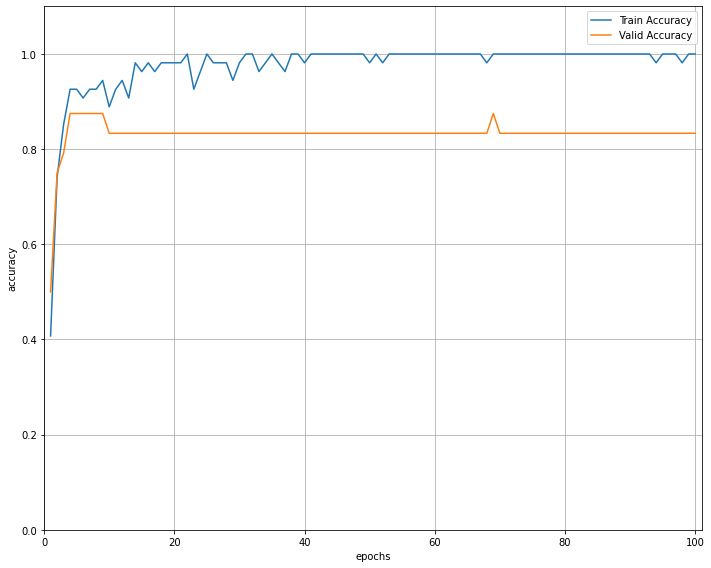

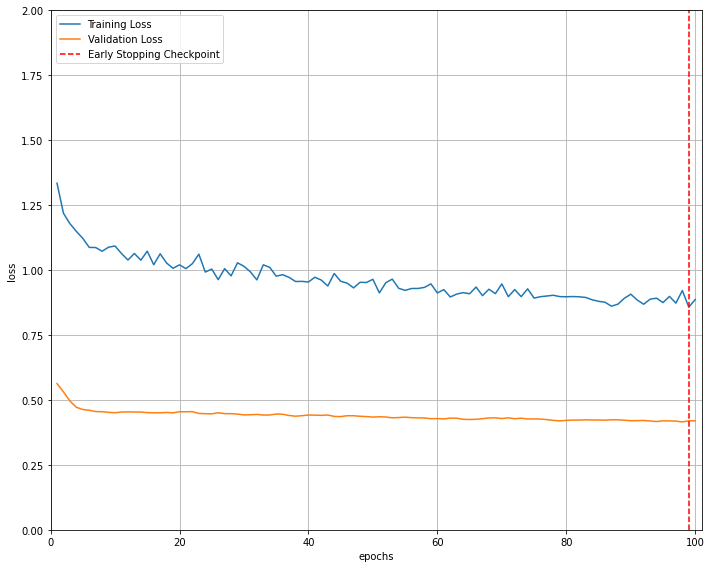

Confusion Matrix Without Normalization


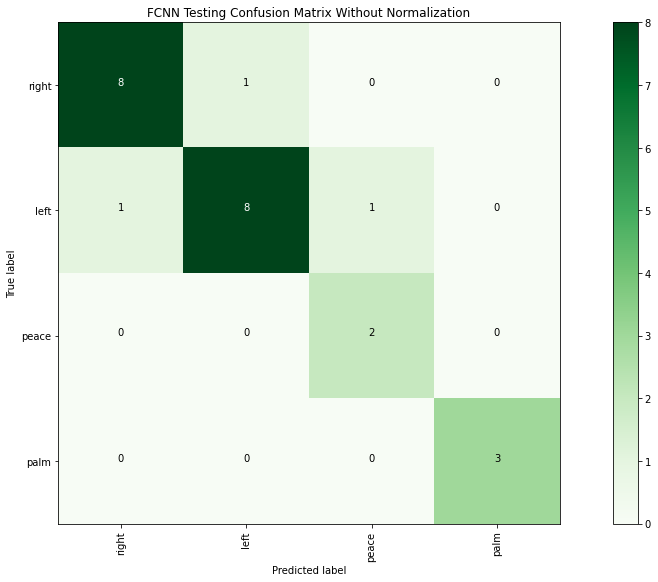

Normalized Confusion Matrix


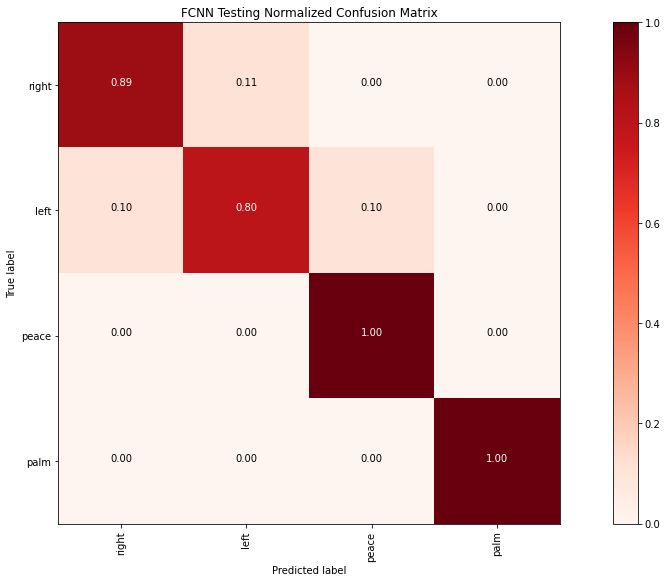

In [ ]:
model = FCNNModel1(input_layer_size=H*W, num_classes=num_classes)
model.load_state_dict(torch.load("FCNNModel1.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["right", "left", "peace", "palm"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='FCNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='FCNN Testing Normalized Confusion Matrix')

In [ ]:
accuracy_score(y_true, y_pred)

0.875

In [ ]:
class FCNNModel2(nn.Module):
    def __init__(self, input_layer_size, num_classes):
        super(FCNNModel2, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_layer_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(8, num_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        out = self.sm(x)
        return out

model = FCNNModel2(input_layer_size=H*W, num_classes=num_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [ ]:
model = FCNNModel2(input_layer_size=H*W, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="FCNNModel2.pth")

100%|██████████| 3/3 [00:00<00:00, 394.83it/s]


epoch=0 train loss=1.361036 test loss=0.590849 train accuracy=0.296 test accuracy=0.417


100%|██████████| 3/3 [00:00<00:00, 437.03it/s]


epoch=1 train loss=1.310106 test loss=0.588526 train accuracy=0.556 test accuracy=0.417


100%|██████████| 3/3 [00:00<00:00, 340.02it/s]


epoch=2 train loss=1.270087 test loss=0.576386 train accuracy=0.648 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 431.97it/s]


epoch=3 train loss=1.268578 test loss=0.560019 train accuracy=0.741 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 643.27it/s]


epoch=4 train loss=1.275052 test loss=0.547232 train accuracy=0.685 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 431.34it/s]


epoch=5 train loss=1.262364 test loss=0.538465 train accuracy=0.741 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 380.64it/s]


epoch=6 train loss=1.231141 test loss=0.535982 train accuracy=0.778 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 408.93it/s]


epoch=7 train loss=1.257429 test loss=0.531192 train accuracy=0.704 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 722.24it/s]


epoch=8 train loss=1.214194 test loss=0.533286 train accuracy=0.926 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 449.44it/s]


epoch=9 train loss=1.261819 test loss=0.530807 train accuracy=0.630 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 355.28it/s]


epoch=10 train loss=1.237091 test loss=0.529413 train accuracy=0.852 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 455.65it/s]


epoch=11 train loss=1.206741 test loss=0.534030 train accuracy=0.889 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 405.09it/s]


epoch=12 train loss=1.208636 test loss=0.532038 train accuracy=0.833 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 513.94it/s]


epoch=13 train loss=1.204115 test loss=0.534876 train accuracy=0.870 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 411.96it/s]


epoch=14 train loss=1.205712 test loss=0.534411 train accuracy=0.889 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 410.75it/s]


epoch=15 train loss=1.237992 test loss=0.528395 train accuracy=0.778 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 677.78it/s]


epoch=16 train loss=1.221128 test loss=0.525061 train accuracy=0.815 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 340.33it/s]


epoch=17 train loss=1.202708 test loss=0.528253 train accuracy=0.870 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 410.48it/s]


epoch=18 train loss=1.206832 test loss=0.528118 train accuracy=0.870 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 339.07it/s]


epoch=19 train loss=1.206553 test loss=0.526968 train accuracy=0.815 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 387.31it/s]


epoch=20 train loss=1.198579 test loss=0.526266 train accuracy=0.907 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 420.00it/s]


epoch=21 train loss=1.202629 test loss=0.527639 train accuracy=0.889 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 287.43it/s]


epoch=22 train loss=1.211549 test loss=0.526516 train accuracy=0.852 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 795.08it/s]


epoch=23 train loss=1.181066 test loss=0.528609 train accuracy=0.870 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 388.42it/s]


epoch=24 train loss=1.194294 test loss=0.523139 train accuracy=0.870 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 436.10it/s]


epoch=25 train loss=1.191363 test loss=0.526616 train accuracy=0.889 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 287.61it/s]


epoch=26 train loss=1.175338 test loss=0.529390 train accuracy=0.944 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 331.53it/s]


epoch=27 train loss=1.186593 test loss=0.530014 train accuracy=0.833 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 455.05it/s]


epoch=28 train loss=1.180482 test loss=0.524203 train accuracy=0.926 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 447.74it/s]


epoch=29 train loss=1.210072 test loss=0.520462 train accuracy=0.833 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 559.17it/s]


epoch=30 train loss=1.206198 test loss=0.516901 train accuracy=0.815 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 381.40it/s]


epoch=31 train loss=1.179128 test loss=0.523971 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 441.85it/s]


epoch=32 train loss=1.198265 test loss=0.522292 train accuracy=0.852 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 357.23it/s]


epoch=33 train loss=1.175103 test loss=0.521430 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 460.47it/s]


epoch=34 train loss=1.170792 test loss=0.521097 train accuracy=0.944 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 399.15it/s]


epoch=35 train loss=1.181488 test loss=0.520827 train accuracy=0.926 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 290.40it/s]


epoch=36 train loss=1.168870 test loss=0.524250 train accuracy=0.907 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 564.59it/s]


epoch=37 train loss=1.165336 test loss=0.525903 train accuracy=0.926 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 435.89it/s]


epoch=38 train loss=1.174100 test loss=0.524666 train accuracy=0.907 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 482.64it/s]


epoch=39 train loss=1.164488 test loss=0.522257 train accuracy=0.907 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 389.67it/s]


epoch=40 train loss=1.198758 test loss=0.522089 train accuracy=0.889 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 359.69it/s]


epoch=41 train loss=1.204985 test loss=0.517501 train accuracy=0.889 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 331.09it/s]


epoch=42 train loss=1.175355 test loss=0.519278 train accuracy=0.944 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 425.26it/s]


epoch=43 train loss=1.163041 test loss=0.525765 train accuracy=0.926 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 499.30it/s]


epoch=44 train loss=1.172954 test loss=0.527915 train accuracy=0.889 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 447.69it/s]


epoch=45 train loss=1.190365 test loss=0.524516 train accuracy=0.889 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 225.15it/s]


epoch=46 train loss=1.142951 test loss=0.524301 train accuracy=0.963 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 339.16it/s]


epoch=47 train loss=1.153429 test loss=0.521990 train accuracy=0.981 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 463.87it/s]


epoch=48 train loss=1.167930 test loss=0.519452 train accuracy=0.870 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 362.04it/s]


epoch=49 train loss=1.138845 test loss=0.520297 train accuracy=0.944 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 330.13it/s]


epoch=50 train loss=1.177864 test loss=0.514897 train accuracy=0.907 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 371.39it/s]


epoch=51 train loss=1.147035 test loss=0.519282 train accuracy=0.963 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 427.42it/s]


epoch=52 train loss=1.147038 test loss=0.520565 train accuracy=0.981 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 481.50it/s]


epoch=53 train loss=1.168984 test loss=0.520626 train accuracy=0.889 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 324.75it/s]


epoch=54 train loss=1.140939 test loss=0.519155 train accuracy=1.000 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 402.59it/s]


epoch=55 train loss=1.161056 test loss=0.518518 train accuracy=0.889 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 442.08it/s]


epoch=56 train loss=1.144409 test loss=0.522240 train accuracy=0.926 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 410.01it/s]


epoch=57 train loss=1.156201 test loss=0.517126 train accuracy=0.944 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 416.20it/s]


epoch=58 train loss=1.151757 test loss=0.514174 train accuracy=0.944 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 456.48it/s]


epoch=59 train loss=1.183187 test loss=0.512026 train accuracy=0.889 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 389.52it/s]


epoch=60 train loss=1.145230 test loss=0.514773 train accuracy=0.963 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 435.12it/s]


epoch=61 train loss=1.140541 test loss=0.516368 train accuracy=0.963 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 433.22it/s]


epoch=62 train loss=1.161698 test loss=0.516535 train accuracy=0.889 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 356.25it/s]


epoch=63 train loss=1.172665 test loss=0.508786 train accuracy=0.852 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 552.68it/s]


epoch=64 train loss=1.172179 test loss=0.506760 train accuracy=0.870 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 419.01it/s]


epoch=65 train loss=1.151028 test loss=0.514938 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 349.45it/s]


epoch=66 train loss=1.137903 test loss=0.516728 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 561.01it/s]


epoch=67 train loss=1.150143 test loss=0.514234 train accuracy=0.944 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 271.99it/s]


epoch=68 train loss=1.120061 test loss=0.518429 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 610.85it/s]


epoch=69 train loss=1.161213 test loss=0.517021 train accuracy=0.889 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 401.54it/s]


epoch=70 train loss=1.164622 test loss=0.511873 train accuracy=0.889 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 892.22it/s]


epoch=71 train loss=1.150515 test loss=0.506856 train accuracy=0.889 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 299.53it/s]


epoch=72 train loss=1.149471 test loss=0.505654 train accuracy=0.907 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 344.78it/s]


epoch=73 train loss=1.124547 test loss=0.506369 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 306.10it/s]


epoch=74 train loss=1.143200 test loss=0.506812 train accuracy=0.907 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 404.82it/s]


epoch=75 train loss=1.152590 test loss=0.502552 train accuracy=0.981 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 439.16it/s]


epoch=76 train loss=1.141799 test loss=0.503160 train accuracy=0.944 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 458.95it/s]


epoch=77 train loss=1.121557 test loss=0.508564 train accuracy=0.981 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 406.87it/s]


epoch=78 train loss=1.125299 test loss=0.503893 train accuracy=0.981 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 434.19it/s]


epoch=79 train loss=1.145426 test loss=0.504943 train accuracy=0.907 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 426.09it/s]


epoch=80 train loss=1.143748 test loss=0.508856 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 459.43it/s]


epoch=81 train loss=1.125255 test loss=0.515690 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 403.41it/s]


epoch=82 train loss=1.128094 test loss=0.509200 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 411.93it/s]


epoch=83 train loss=1.117618 test loss=0.505453 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 471.68it/s]


epoch=84 train loss=1.117644 test loss=0.507604 train accuracy=1.000 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 447.65it/s]


epoch=85 train loss=1.112501 test loss=0.513408 train accuracy=0.944 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 364.45it/s]


epoch=86 train loss=1.142883 test loss=0.512473 train accuracy=0.944 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 325.43it/s]


epoch=87 train loss=1.131753 test loss=0.512966 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 352.49it/s]


epoch=88 train loss=1.102942 test loss=0.513931 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 446.33it/s]


epoch=89 train loss=1.092417 test loss=0.511457 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 250.08it/s]


epoch=90 train loss=1.158342 test loss=0.505471 train accuracy=0.870 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 383.47it/s]


epoch=91 train loss=1.189821 test loss=0.494247 train accuracy=0.870 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 320.80it/s]


epoch=92 train loss=1.125937 test loss=0.498696 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 358.77it/s]


epoch=93 train loss=1.140975 test loss=0.498980 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 329.48it/s]


epoch=94 train loss=1.131409 test loss=0.504412 train accuracy=0.907 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 437.27it/s]


epoch=95 train loss=1.096102 test loss=0.509231 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 358.51it/s]


epoch=96 train loss=1.104923 test loss=0.510322 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 389.11it/s]


epoch=97 train loss=1.114588 test loss=0.506724 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 368.37it/s]


epoch=98 train loss=1.113474 test loss=0.506898 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 365.35it/s]

epoch=99 train loss=1.103436 test loss=0.506675 train accuracy=0.981 test accuracy=0.833


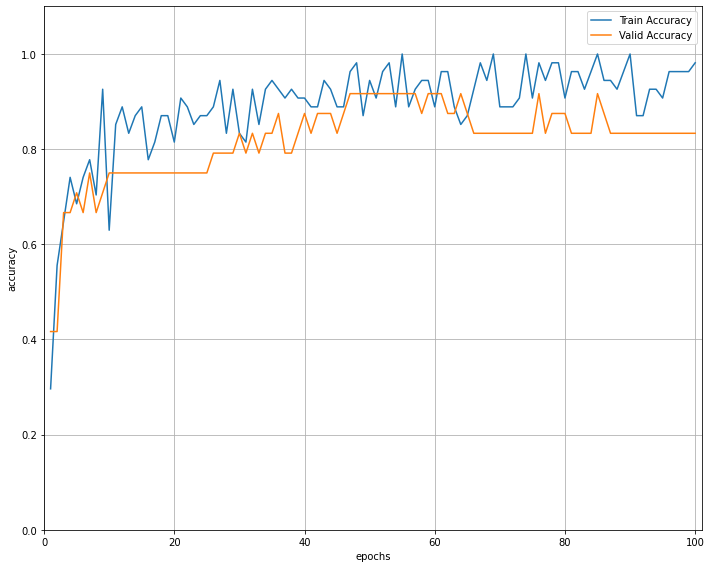

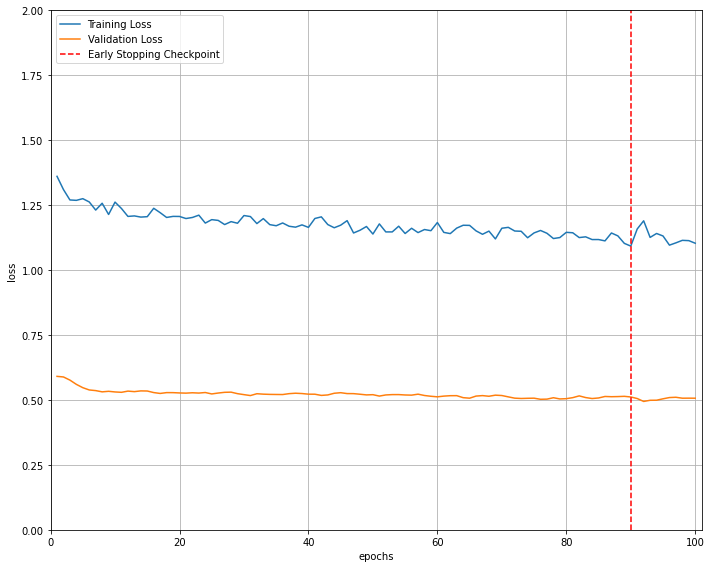

Confusion Matrix Without Normalization


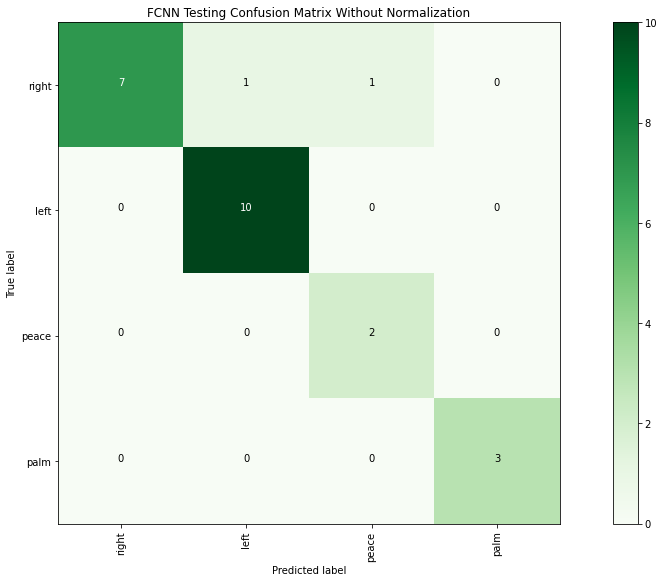

Normalized Confusion Matrix


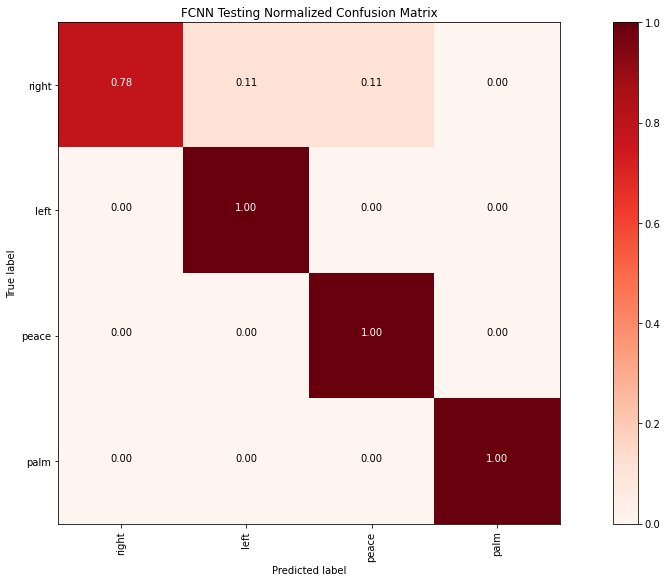

In [ ]:
model = FCNNModel2(input_layer_size=H*W, num_classes=num_classes)
model.load_state_dict(torch.load("FCNNModel2.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["right", "left", "peace", "palm"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='FCNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='FCNN Testing Normalized Confusion Matrix')

In [ ]:
accuracy_score(y_true, y_pred)

0.9166666666666666

In [ ]:
class FCNNModel3(nn.Module):
    def __init__(self, input_layer_size, num_classes):
        super(FCNNModel3, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_layer_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.sm(x)
        return out

model = FCNNModel3(input_layer_size=H*W, num_classes=num_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [ ]:
model = FCNNModel3(input_layer_size=H*W, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="FCNNModel3.pth")

100%|██████████| 3/3 [00:00<00:00, 420.33it/s]


epoch=0 train loss=1.180843 test loss=0.526487 train accuracy=0.685 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 892.47it/s]


epoch=1 train loss=0.984791 test loss=0.445072 train accuracy=0.815 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 425.18it/s]


epoch=2 train loss=0.908710 test loss=0.396483 train accuracy=0.889 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 507.76it/s]


epoch=3 train loss=0.839816 test loss=0.379296 train accuracy=0.926 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 520.58it/s]


epoch=4 train loss=0.858251 test loss=0.374510 train accuracy=0.926 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 515.95it/s]


epoch=5 train loss=0.832001 test loss=0.372349 train accuracy=0.944 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 375.60it/s]


epoch=6 train loss=0.812528 test loss=0.371920 train accuracy=0.963 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 567.36it/s]


epoch=7 train loss=0.835709 test loss=0.372114 train accuracy=0.963 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 684.90it/s]


epoch=8 train loss=0.798427 test loss=0.377466 train accuracy=0.963 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 465.46it/s]


epoch=9 train loss=0.783835 test loss=0.380702 train accuracy=0.981 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 497.66it/s]


epoch=10 train loss=0.793846 test loss=0.380801 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 553.44it/s]


epoch=11 train loss=0.797305 test loss=0.381007 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 548.37it/s]


epoch=12 train loss=0.774186 test loss=0.383863 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 488.71it/s]


epoch=13 train loss=0.797424 test loss=0.386143 train accuracy=0.963 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 578.34it/s]


epoch=14 train loss=0.765594 test loss=0.382240 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 535.19it/s]


epoch=15 train loss=0.763198 test loss=0.381265 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 647.04it/s]


epoch=16 train loss=0.760098 test loss=0.380085 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 413.86it/s]


epoch=17 train loss=0.791503 test loss=0.380117 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 662.36it/s]


epoch=18 train loss=0.770128 test loss=0.379786 train accuracy=1.000 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 530.25it/s]


epoch=19 train loss=0.781732 test loss=0.381712 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 656.87it/s]


epoch=20 train loss=0.756706 test loss=0.383739 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 402.45it/s]


epoch=21 train loss=0.766472 test loss=0.384958 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 618.54it/s]


epoch=22 train loss=0.760366 test loss=0.381430 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 518.43it/s]


epoch=23 train loss=0.766266 test loss=0.381164 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 458.86it/s]


epoch=24 train loss=0.758804 test loss=0.380585 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 496.52it/s]


epoch=25 train loss=0.759529 test loss=0.377663 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 545.64it/s]


epoch=26 train loss=0.750280 test loss=0.380445 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 624.09it/s]


epoch=27 train loss=0.754947 test loss=0.380370 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 508.85it/s]


epoch=28 train loss=0.753548 test loss=0.380082 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 615.57it/s]


epoch=29 train loss=0.759938 test loss=0.379728 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 713.92it/s]


epoch=30 train loss=0.751634 test loss=0.382477 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 309.52it/s]


epoch=31 train loss=0.752872 test loss=0.383075 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 563.80it/s]


epoch=32 train loss=0.749355 test loss=0.382409 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 485.23it/s]


epoch=33 train loss=0.759240 test loss=0.384959 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 433.58it/s]


epoch=34 train loss=0.749027 test loss=0.385939 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 537.50it/s]


epoch=35 train loss=0.754520 test loss=0.384914 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 411.35it/s]


epoch=36 train loss=0.753124 test loss=0.385116 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 314.75it/s]


epoch=37 train loss=0.750038 test loss=0.384335 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 669.80it/s]


epoch=38 train loss=0.758420 test loss=0.385038 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 542.93it/s]


epoch=39 train loss=0.768928 test loss=0.384764 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 472.53it/s]


epoch=40 train loss=0.757408 test loss=0.391299 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 780.38it/s]


epoch=41 train loss=0.748094 test loss=0.392490 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 586.59it/s]


epoch=42 train loss=0.758955 test loss=0.391577 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 413.93it/s]


epoch=43 train loss=0.748532 test loss=0.385922 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 657.31it/s]


epoch=44 train loss=0.750600 test loss=0.384731 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 351.83it/s]


epoch=45 train loss=0.759102 test loss=0.383017 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 616.60it/s]


epoch=46 train loss=0.757267 test loss=0.392264 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 332.12it/s]


epoch=47 train loss=0.768903 test loss=0.395076 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 707.34it/s]


epoch=48 train loss=0.751708 test loss=0.392878 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 604.13it/s]


epoch=49 train loss=0.751024 test loss=0.390319 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 639.05it/s]


epoch=50 train loss=0.753639 test loss=0.389058 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 703.23it/s]


epoch=51 train loss=0.747563 test loss=0.388673 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 410.66it/s]


epoch=52 train loss=0.749116 test loss=0.388972 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 624.25it/s]


epoch=53 train loss=0.751886 test loss=0.386271 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 420.19it/s]


epoch=54 train loss=0.750986 test loss=0.385676 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 693.92it/s]


epoch=55 train loss=0.751998 test loss=0.390532 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 608.58it/s]


epoch=56 train loss=0.750386 test loss=0.389219 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 517.16it/s]


epoch=57 train loss=0.748190 test loss=0.389606 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 391.21it/s]


epoch=58 train loss=0.751224 test loss=0.386921 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 631.23it/s]


epoch=59 train loss=0.784362 test loss=0.388945 train accuracy=0.981 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 556.96it/s]


epoch=60 train loss=0.748923 test loss=0.392649 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 645.81it/s]


epoch=61 train loss=0.754151 test loss=0.389508 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 432.39it/s]


epoch=62 train loss=0.752238 test loss=0.389791 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 601.94it/s]


epoch=63 train loss=0.746912 test loss=0.387101 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 572.55it/s]


epoch=64 train loss=0.752733 test loss=0.387238 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 508.85it/s]


epoch=65 train loss=0.751753 test loss=0.382976 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 374.67it/s]


epoch=66 train loss=0.749445 test loss=0.378962 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 454.32it/s]


epoch=67 train loss=0.747989 test loss=0.377533 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 614.64it/s]


epoch=68 train loss=0.756150 test loss=0.376254 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 765.01it/s]


epoch=69 train loss=0.748474 test loss=0.377371 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 533.58it/s]


epoch=70 train loss=0.759251 test loss=0.379808 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 417.57it/s]


epoch=71 train loss=0.747172 test loss=0.382112 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 538.93it/s]


epoch=72 train loss=0.748241 test loss=0.378751 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 589.53it/s]


epoch=73 train loss=0.746090 test loss=0.379911 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 355.89it/s]


epoch=74 train loss=0.746474 test loss=0.380689 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 479.75it/s]


epoch=75 train loss=0.751539 test loss=0.380454 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 455.87it/s]


epoch=76 train loss=0.745459 test loss=0.380276 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 444.03it/s]


epoch=77 train loss=0.747101 test loss=0.379685 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 528.54it/s]


epoch=78 train loss=0.750293 test loss=0.379399 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 567.16it/s]


epoch=79 train loss=0.745194 test loss=0.380388 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 444.12it/s]


epoch=80 train loss=0.754477 test loss=0.380337 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 378.31it/s]


epoch=81 train loss=0.746263 test loss=0.381584 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 585.47it/s]


epoch=82 train loss=0.746717 test loss=0.379761 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 667.99it/s]


epoch=83 train loss=0.752110 test loss=0.380204 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 563.52it/s]


epoch=84 train loss=0.748514 test loss=0.383493 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 661.49it/s]


epoch=85 train loss=0.753838 test loss=0.379347 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 625.14it/s]


epoch=86 train loss=0.747052 test loss=0.378551 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 433.21it/s]


epoch=87 train loss=0.746152 test loss=0.378912 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 517.75it/s]


epoch=88 train loss=0.747630 test loss=0.377499 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 540.29it/s]


epoch=89 train loss=0.747520 test loss=0.375549 train accuracy=1.000 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 359.97it/s]


epoch=90 train loss=0.750865 test loss=0.375468 train accuracy=1.000 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 482.31it/s]


epoch=91 train loss=0.746074 test loss=0.378382 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 466.62it/s]


epoch=92 train loss=0.771309 test loss=0.381231 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 534.24it/s]


epoch=93 train loss=0.750867 test loss=0.378247 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 517.73it/s]


epoch=94 train loss=0.748813 test loss=0.382951 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 505.78it/s]


epoch=95 train loss=0.746888 test loss=0.386035 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 501.37it/s]


epoch=96 train loss=0.752520 test loss=0.391058 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 782.23it/s]


epoch=97 train loss=0.747192 test loss=0.386406 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 562.36it/s]


epoch=98 train loss=0.748647 test loss=0.384748 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 443.97it/s]

epoch=99 train loss=0.750862 test loss=0.381978 train accuracy=1.000 test accuracy=0.833


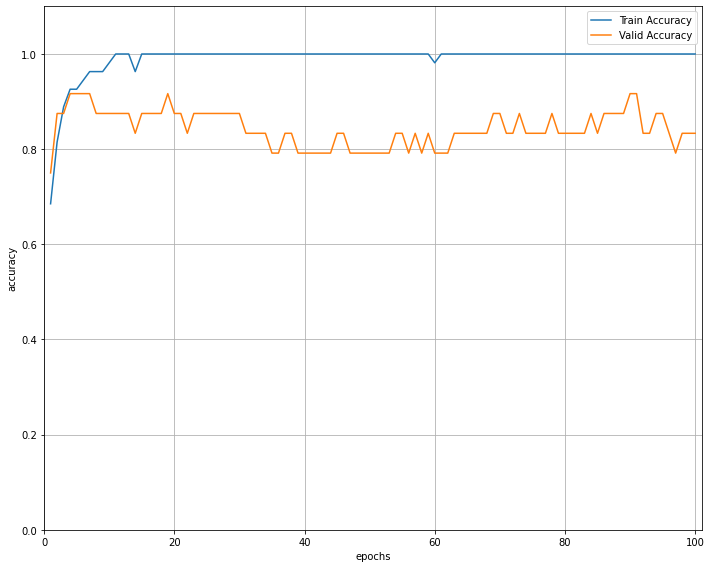

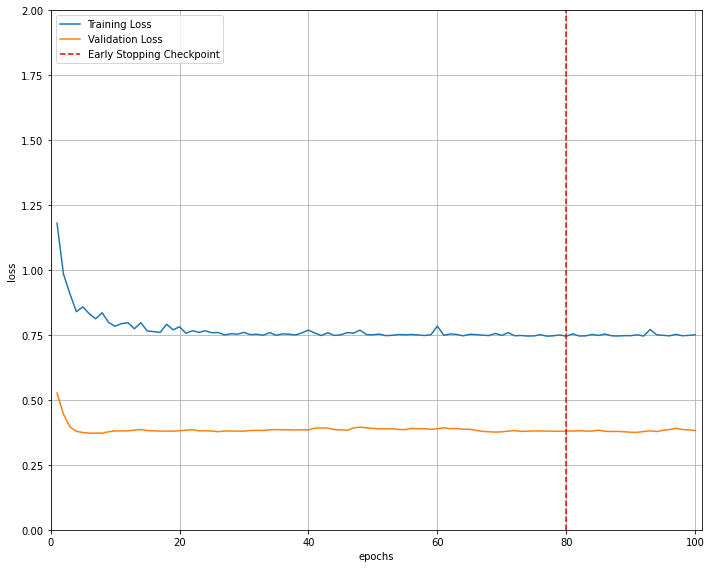

Confusion Matrix Without Normalization


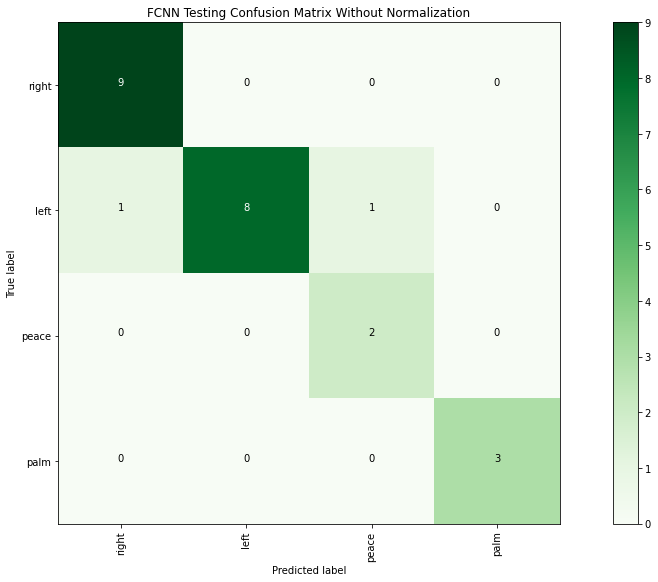

Normalized Confusion Matrix


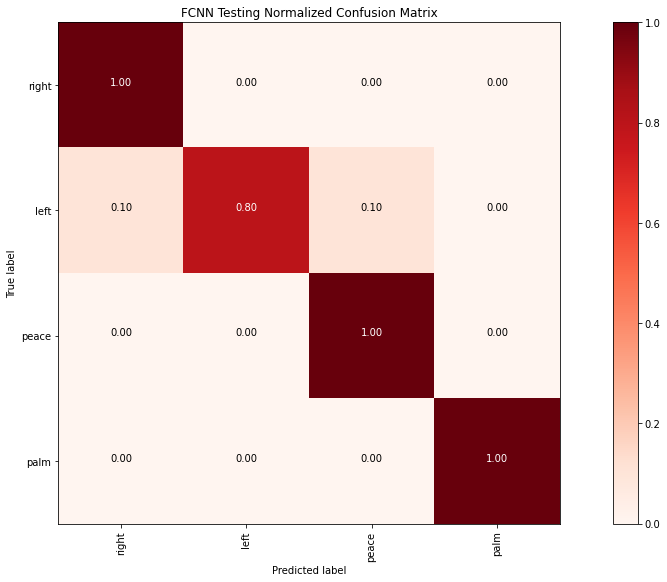

In [ ]:
model = FCNNModel3(input_layer_size=H*W, num_classes=num_classes)
model.load_state_dict(torch.load("FCNNModel3.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["right", "left", "peace", "palm"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='FCNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='FCNN Testing Normalized Confusion Matrix')

In [ ]:
accuracy_score(y_true, y_pred)

0.9166666666666666

In [ ]:
class FCNNModel4(nn.Module):
    def __init__(self, input_layer_size, num_classes):
        super(FCNNModel4, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_layer_size, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(inplace=True),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.sm(x)
        return out

model = FCNNModel4(input_layer_size=H*W, num_classes=num_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [ ]:
model = FCNNModel4(input_layer_size=H*W, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="FCNNModel4.pth")

100%|██████████| 3/3 [00:00<00:00, 566.90it/s]


epoch=0 train loss=1.290284 test loss=0.547152 train accuracy=0.426 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 817.60it/s]


epoch=1 train loss=1.061388 test loss=0.481414 train accuracy=0.796 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 506.27it/s]


epoch=2 train loss=0.930134 test loss=0.427797 train accuracy=0.926 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 533.65it/s]


epoch=3 train loss=0.881860 test loss=0.395870 train accuracy=0.926 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 417.09it/s]


epoch=4 train loss=0.882044 test loss=0.384767 train accuracy=0.926 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 352.21it/s]


epoch=5 train loss=0.871352 test loss=0.380358 train accuracy=0.944 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 274.19it/s]


epoch=6 train loss=0.842977 test loss=0.376808 train accuracy=0.944 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 601.59it/s]


epoch=7 train loss=0.879335 test loss=0.374950 train accuracy=0.944 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 715.34it/s]


epoch=8 train loss=0.815270 test loss=0.375321 train accuracy=0.981 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 547.92it/s]


epoch=9 train loss=0.805428 test loss=0.378290 train accuracy=0.981 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 479.48it/s]


epoch=10 train loss=0.795423 test loss=0.380332 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 537.39it/s]


epoch=11 train loss=0.813638 test loss=0.381459 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 729.66it/s]


epoch=12 train loss=0.784579 test loss=0.383598 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 425.21it/s]


epoch=13 train loss=0.794779 test loss=0.381762 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 360.75it/s]


epoch=14 train loss=0.776400 test loss=0.381078 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 677.45it/s]


epoch=15 train loss=0.818861 test loss=0.381927 train accuracy=0.944 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 275.16it/s]


epoch=16 train loss=0.798284 test loss=0.381840 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 484.44it/s]


epoch=17 train loss=0.792184 test loss=0.383286 train accuracy=0.981 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 467.14it/s]


epoch=18 train loss=0.831010 test loss=0.384018 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 529.03it/s]


epoch=19 train loss=0.802873 test loss=0.385736 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 469.46it/s]


epoch=20 train loss=0.770677 test loss=0.385365 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 519.89it/s]


epoch=21 train loss=0.782801 test loss=0.387482 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 402.59it/s]


epoch=22 train loss=0.770704 test loss=0.389217 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 622.15it/s]


epoch=23 train loss=0.765688 test loss=0.387615 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 567.77it/s]


epoch=24 train loss=0.765597 test loss=0.385314 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 541.39it/s]


epoch=25 train loss=0.763222 test loss=0.384193 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 472.63it/s]


epoch=26 train loss=0.775633 test loss=0.385320 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 455.46it/s]


epoch=27 train loss=0.768742 test loss=0.383434 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 467.59it/s]


epoch=28 train loss=0.756202 test loss=0.382712 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 476.23it/s]


epoch=29 train loss=0.755307 test loss=0.384117 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 776.48it/s]


epoch=30 train loss=0.762713 test loss=0.383998 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 550.53it/s]


epoch=31 train loss=0.752914 test loss=0.383235 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 454.01it/s]


epoch=32 train loss=0.759452 test loss=0.382585 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 480.50it/s]


epoch=33 train loss=0.780581 test loss=0.382023 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 417.54it/s]


epoch=34 train loss=0.770921 test loss=0.386229 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 534.35it/s]


epoch=35 train loss=0.769139 test loss=0.392421 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 578.90it/s]


epoch=36 train loss=0.756754 test loss=0.392333 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 403.86it/s]


epoch=37 train loss=0.771876 test loss=0.389970 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 475.15it/s]


epoch=38 train loss=0.763839 test loss=0.387858 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 503.88it/s]


epoch=39 train loss=0.756618 test loss=0.386682 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 438.14it/s]


epoch=40 train loss=0.772750 test loss=0.384235 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 444.72it/s]


epoch=41 train loss=0.759647 test loss=0.383924 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 451.83it/s]


epoch=42 train loss=0.752582 test loss=0.386582 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 458.76it/s]


epoch=43 train loss=0.758871 test loss=0.383250 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 563.98it/s]


epoch=44 train loss=0.776214 test loss=0.383162 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 639.41it/s]


epoch=45 train loss=0.759185 test loss=0.385730 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 982.81it/s]


epoch=46 train loss=0.751571 test loss=0.387331 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 507.78it/s]


epoch=47 train loss=0.751448 test loss=0.387659 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 397.50it/s]


epoch=48 train loss=0.773105 test loss=0.386882 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 505.03it/s]


epoch=49 train loss=0.772511 test loss=0.385248 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 435.71it/s]


epoch=50 train loss=0.758488 test loss=0.382957 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 438.80it/s]


epoch=51 train loss=0.760144 test loss=0.379727 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 469.62it/s]


epoch=52 train loss=0.755525 test loss=0.377707 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 595.19it/s]


epoch=53 train loss=0.756661 test loss=0.379833 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 737.48it/s]


epoch=54 train loss=0.757337 test loss=0.379304 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 568.67it/s]


epoch=55 train loss=0.750846 test loss=0.380508 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 412.38it/s]


epoch=56 train loss=0.755568 test loss=0.381892 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 472.72it/s]


epoch=57 train loss=0.763556 test loss=0.381582 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 288.28it/s]


epoch=58 train loss=0.756022 test loss=0.382732 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 580.71it/s]


epoch=59 train loss=0.764719 test loss=0.381639 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 624.83it/s]


epoch=60 train loss=0.769391 test loss=0.382550 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 372.46it/s]


epoch=61 train loss=0.753306 test loss=0.380745 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 432.88it/s]


epoch=62 train loss=0.750036 test loss=0.380877 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 603.18it/s]


epoch=63 train loss=0.766883 test loss=0.381281 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 491.33it/s]


epoch=64 train loss=0.808856 test loss=0.381599 train accuracy=0.981 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 404.88it/s]


epoch=65 train loss=0.752204 test loss=0.381990 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 633.90it/s]


epoch=66 train loss=0.770292 test loss=0.379079 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 883.57it/s]


epoch=67 train loss=0.756172 test loss=0.382418 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 718.24it/s]


epoch=68 train loss=0.757032 test loss=0.385829 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 476.23it/s]


epoch=69 train loss=0.758880 test loss=0.387462 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 540.27it/s]


epoch=70 train loss=0.753254 test loss=0.386311 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 401.37it/s]


epoch=71 train loss=0.763946 test loss=0.383969 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 632.72it/s]


epoch=72 train loss=0.758533 test loss=0.381383 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 702.33it/s]


epoch=73 train loss=0.749835 test loss=0.381558 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 702.09it/s]


epoch=74 train loss=0.748203 test loss=0.381419 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 524.27it/s]


epoch=75 train loss=0.749311 test loss=0.381334 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 476.14it/s]


epoch=76 train loss=0.750481 test loss=0.380631 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 498.29it/s]


epoch=77 train loss=0.752605 test loss=0.381460 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 231.70it/s]


epoch=78 train loss=0.747903 test loss=0.382120 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 437.94it/s]


epoch=79 train loss=0.751976 test loss=0.382195 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 641.07it/s]


epoch=80 train loss=0.749129 test loss=0.380334 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 501.65it/s]


epoch=81 train loss=0.750970 test loss=0.381928 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 615.87it/s]


epoch=82 train loss=0.750163 test loss=0.380238 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 322.74it/s]


epoch=83 train loss=0.751247 test loss=0.379899 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 557.85it/s]


epoch=84 train loss=0.752832 test loss=0.379657 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 431.08it/s]


epoch=85 train loss=0.747747 test loss=0.380372 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 611.18it/s]


epoch=86 train loss=0.766280 test loss=0.381804 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 471.46it/s]


epoch=87 train loss=0.747276 test loss=0.382414 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 541.76it/s]


epoch=88 train loss=0.760859 test loss=0.386925 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 778.93it/s]


epoch=89 train loss=0.748680 test loss=0.394061 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 554.75it/s]


epoch=90 train loss=0.775056 test loss=0.390623 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 723.41it/s]


epoch=91 train loss=0.749506 test loss=0.387242 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 784.32it/s]


epoch=92 train loss=0.754915 test loss=0.385836 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 408.64it/s]


epoch=93 train loss=0.756575 test loss=0.384011 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 447.14it/s]


epoch=94 train loss=0.752245 test loss=0.380835 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 1030.88it/s]


epoch=95 train loss=0.749687 test loss=0.379992 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 384.41it/s]


epoch=96 train loss=0.746948 test loss=0.381166 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 427.82it/s]


epoch=97 train loss=0.750669 test loss=0.381750 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 470.20it/s]


epoch=98 train loss=0.759615 test loss=0.381862 train accuracy=1.000 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 535.76it/s]

epoch=99 train loss=0.752048 test loss=0.383832 train accuracy=1.000 test accuracy=0.875


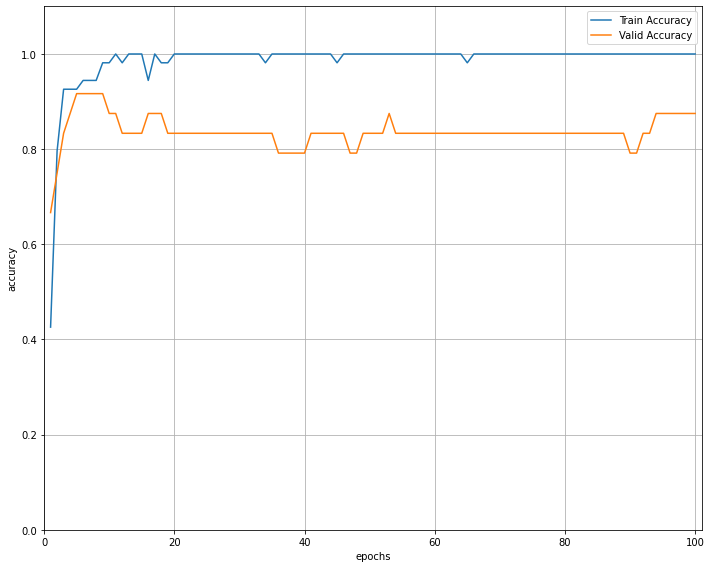

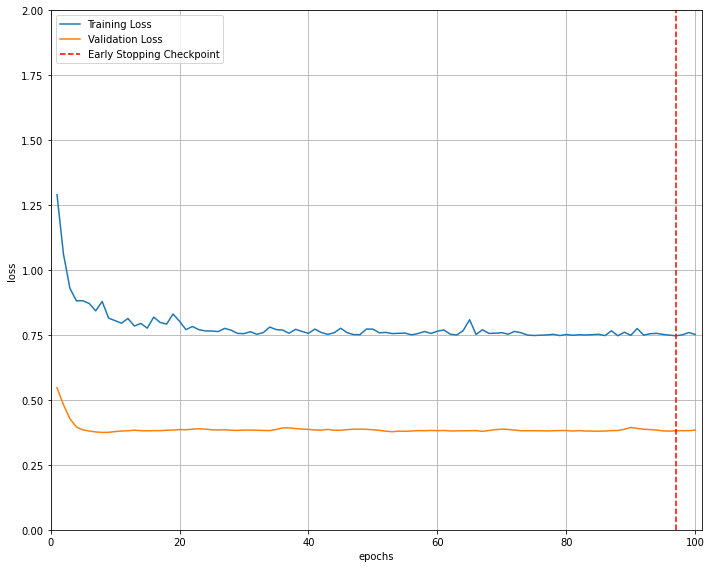

Confusion Matrix Without Normalization


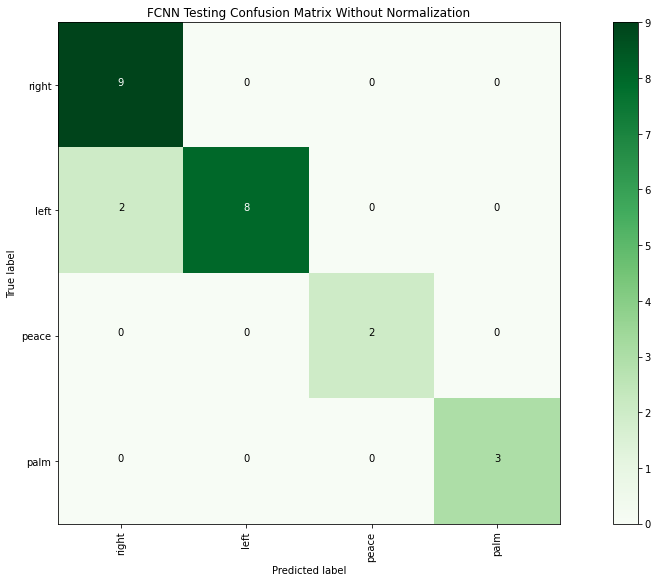

Normalized Confusion Matrix


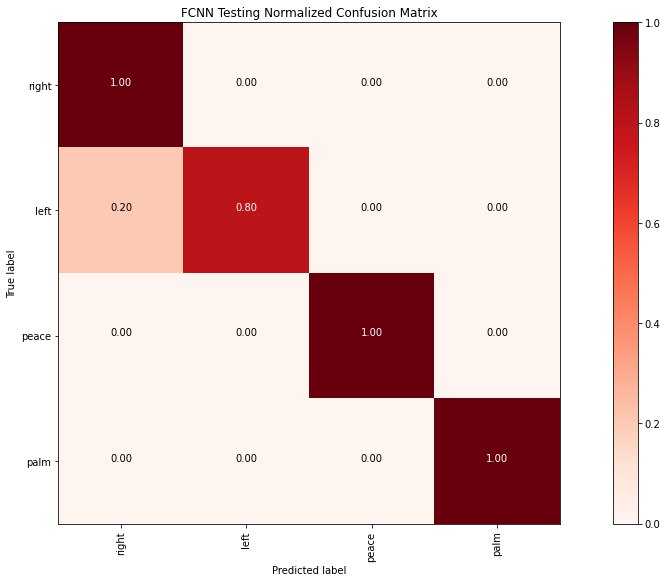

In [ ]:
model = FCNNModel4(input_layer_size=H*W, num_classes=num_classes)
model.load_state_dict(torch.load("FCNNModel4.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["right", "left", "peace", "palm"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='FCNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='FCNN Testing Normalized Confusion Matrix')

In [ ]:
accuracy_score(y_true, y_pred)

0.9166666666666666